# Importing and calling data files


In [34]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import os
#import reionizer
import glob
import astropy
import astropy.cosmology
from astropy.cosmology import Planck15 as P15
from astropy import units as u
from astropy import constants as const
from scipy import interpolate




In [35]:
def insensitive_glob(pattern):
    """
    Case insensitive find file names
    """
    def either(c):
        return '[%s%s]'%(c.lower(),c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either,pattern)))

#Call UV LF data files
LFz_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' #calls directory
LFz_dir = LFz_data_dir+'MTT15_UVLF/LF_pred/' #inside models folder call MTT15_UVLF/LF_pred/ folder
LFz_files = sorted(insensitive_glob(LFz_dir+'LF_pred_z*.txt')) 
#calls each file in modelled data * will be replaced with corresponding zval

#Calling EW files and their Muv values
pW_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
pW_dir = pW_data_dir+'M18_z=7.0_lnpWobs_Muv/' #inside models folder call M18_z=7.0_lnpWobs_Muv folder
pW_files = sorted(insensitive_glob(pW_dir+'ln_pWobs_*.txt')) #calls each file in modelled data * will be replaced with corresponding xHI

#Calling Konno data file
K_data_dir = os.environ['LYA_DATA_DIR']+'data/models/' 
K_dir = pW_data_dir+'Lya_LF_Konno/' 
K_files = sorted(insensitive_glob(K_dir+'Lya_LF_Konno_z*.txt')) 



# Methodology
## Defining function to call files


In [38]:
#Function used to load files
def load_uvf_pandas(ufl_filename): 
    """
    Load table into pandas df
    """
    uvf_tab_df = pd.read_csv(ufl_filename, skiprows=1, delim_whitespace=True)
    
    # Shuffle the column names to remove the '#' from the first column
    uvf_tab_df.columns = np.roll(uvf_tab_df.columns, -1)

    # Cut off the last (empty) column
    uvf_tab_df = uvf_tab_df.iloc[:, :-1]

    return uvf_tab_df



#Call UV LF files by calling file name at specific z value 
LFz_tab = np.array([float(f.split('LF_pred_z')[-1].split('.txt')[0]) for f in LFz_files]) 


#Call xHI, EW files
xHI_tab = np.array([float(f.split('xHI=')[-1].split('.txt')[0]) for f in pW_files]) 

#Call Konno z value files
Konno_tab = np.array([float(f.split('z')[-1].split('.txt')[0]) for f in K_files])

#Call EW file with xHI = 0.01 
#global pW_tab
pW_tab = load_uvf_pandas(pW_files[0]) 

#Get Muv values from EW file as an array to use
Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])



## Defining constants and evaluating equations for given z value. Interpolating data between UV LF and Lya EW, Lya LF and L Grid

In [39]:
#Constants and constraints
xHI_array = np.array([0.29]) #chosen xHI value
zval_test = np.array([5.9]) #chosen redshifts
Konno_zval = np.array([5.7,6.6])
Muv_array = np.array([-18.0,-22.0,-16.0]) #chosen Muv to test lum_lya vs Muv similar to EW vs Muv
beta = -2.0 #usually -2 for high z galaxies as per spectrum as power law
pc_10 = 10 * u.pc #1 pc to Mpc
wl_lya = 1216 * u.Angstrom #angstrom
wl_uv = 1500 * u.Angstrom #angstrom
f0 = 3.631e-20 * (u.erg/u.s) * (u.cm**(-2)) * (u.Hz**(-1)) #flux_0 in erg s^-1 cm^-2 Hz^-1
c = const.c #speed of light
lum_grid = np.logspace(42.5,44) #shape = (50,)
log10_lg = np.log10(lum_grid) #log10 luminosity grid in order to plot it on log10 scale similar to past works

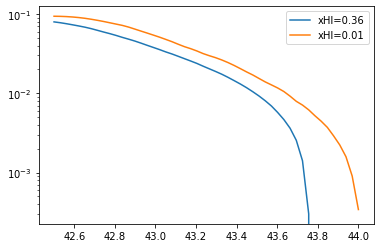

In [40]:
#Defining lya LF function and all necessary eqs needed 

def make_lya_LF(zval_test, xHI_test):
    
    #Calling UV and EW files to obtain z and xHI values
    LFz_file = sorted(insensitive_glob(LFz_dir+ f'LF_pred_z{zval_test}.txt'))[0] 
    pW_file = sorted(insensitive_glob(pW_dir+f'ln_pWobs_*{xHI_test}.txt'))[0]
    
    
    #Load in z value file
    LF_tab = load_uvf_pandas(LFz_file) 
    

    #Load in xHI value file
    pW_tab = load_uvf_pandas(pW_file)
   
    
    #Get Muv values from file as an array to use
    Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])
        
    
    #Interpolating UV LF Muv and ndens values into a 1d array
    LF_interp = interpolate.interp1d(LF_tab['Muv'],LF_tab['ndens']) #old values
    new_ndens = LF_interp(Muv_EW)

    
    #Defines distance modulus
    d_l = P15.luminosity_distance(zval_test) 
    
    
    #Define apparent magnitude equation
    def muv(Muv_EW,d_l,zval_test): 
        p1 = Muv_EW
        p2 = 5*(np.log10((d_l/pc_10).to(u.pc/u.pc))) #convert d_l/pc_10 to pc units and then dimensionless
        p3 = 2.5*(beta+1.0)*np.log10(zval_test+1.0)
        ans = p1 + p2 + p3

        return ans
    muv = muv(Muv_EW,d_l,zval_test)


    #Flux density of UV continuum at Lya wavelength from Muv for given zvals
    fd_uv = f0 * (10**(-0.4*muv)) *(c/(wl_lya**2)) *((wl_lya/wl_uv)**(beta+2.0))
    fd_units = fd_uv.to(u.erg/u.s* (u.cm**(-2))/u.Angstrom) ##use this to show units

    
    #Jacobian - partial EW / partial Lya Luminosity for given zvals 
    jacobian = 1/((4*np.pi*d_l**2.)*fd_units)

    
    # Flux_Lya
    f_lya = np.outer(pW_tab['W'],fd_units) * u.Angstrom

    
    #Lya luminosity 
    lum_lya = (f_lya * (4*np.pi*d_l**2.)).to(u.erg/u.s)
    
    
    #Drops first column of EW values
    new_pW_tab = np.exp(pW_tab.drop('W',axis=1))
    #new_pW_tab = pW_tab.drop('W',axis=1) this was original code, was changed to exponential form

    
    #EW values for each Muv in EW file
    pEW_vals = np.array(new_pW_tab) 


    # P(Lya|Muv)
    pLya = jacobian * pEW_vals

    
    #Normalizes pLya to correctly plot lum_lya vs pLya
    A1 = pLya[0] #first term of p(L) integral, where these lum = 0 (the height in y)(-inf to 0)
    integral = np.trapz(pLya[1:].T,lum_lya.value[1:].T) #second term for lum>0 (L>0 to inf) transposed to correct matrix 
    sum_int = A1 + integral #This is whole integral of p(L)dL
    norm_pLya = pLya / sum_int #new normalized pLya, divide original pLya values by integral to normalize

    new_A1 = norm_pLya[0]
    integral2 = np.trapz(norm_pLya[1:].T,lum_lya.value[1:].T)
    new_sum = new_A1 + integral2 #verifies that new normalized integral adds up to 1 
    assert(new_sum.value.all() == 1.)

    
    #Define an empty matrix in order to fill later with luminosity grid values and Muv values
    new_pLya = np.zeros((len(lum_grid), len(Muv_EW))) 

    for mm,Muv in enumerate (Muv_EW):
        
        #Interpolating pLya and ndens values into a 1d array
        LF_interp = interpolate.interp1d(lum_lya[:,mm],norm_pLya[:,mm],fill_value='extrapolate') #old values, MUST BE 1D
        new_pLya[:,mm] = LF_interp(lum_grid) #column values of pLya

        
        #Product of UVLF ndens values * pLya in new luminosity grid
        product_LF = new_ndens * new_pLya 

        
        #Integral of this product = Lya LF (missing fudge factor corrections)
        lya_LF = np.trapz(product_LF) 

        
        #Log10 of Lya LF is lya_LF value * Jacobian - partial L / partial log10(L)
        log10_LF = lya_LF*np.log(10)*lum_grid

    return log10_LF
# log10_LF = make_lya_LF(zval_test = 5.9,xHI_test = 0.36)
# plt.semilogy(log10_lg, log10_LF, label = 'xHI=0.36')
# log10_LF = make_lya_LF(zval_test = 5.9,xHI_test = 0.01)
# plt.semilogy(log10_lg, log10_LF,label = 'xHI=0.01')
# plt.legend()

Text(0, 0.5, '$\\phi(log_{10}(\\mathrm{L_\\alpha}))\\ [Mpc^-3]$')

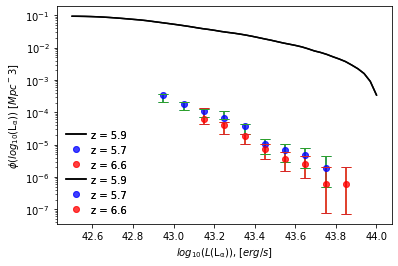

In [95]:
for zz,zval2 in enumerate (LFz_tab): 
    if zval2 in zval_test:
                   
        if zval2 == 5.9:
            my_color = 'gray'               
        else:
            my_color = 'purple'  

#Within if statement, this is for identifying xHI legend (values and corresponding colors)
        for mm,Muv in enumerate (Muv_array):
            if mm == 0: #first item in Muv_array, i.e. -18.0
                ls = 'solid'
                label = 'z = %.1f'%zval2
            elif mm == 1: #second item in Muv_array, i.e. -22.0 (will not show on xHI legend)
                ls = 'dashed'
                label = None
            elif mm == 2: # Third item in Muv_array, i.e. -16.0
                ls = 'dashdot'
                plt.semilogy(log10_lg, log10_LF, color = 'black', label='z = 5.9')
        for yy,zval3 in enumerate(Konno_tab):
            if zval3 in Konno_zval:
                Ko_tab = load_uvf_pandas(K_files[yy])
                yerr_l = 10**(Ko_tab['log(ndens)']) - 10**(Ko_tab['ndens_l2']) 
                yerr_u = 10**(Ko_tab['ndens_u2']) - 10**(Ko_tab['log(ndens)'])
                yerror = [yerr_l,yerr_u]

                if zval3 == 5.7:
                    my_color = 'bo'
                    label2 = 'z = %.1f'%zval3
                elif zval3 == 6.6:
                    my_color = 'ro'
                    label2 = 'z = %.1f'%zval3


            #These are all different plots that use the same info in order to plot, that can be commented out 

#                     plt.loglog(lum_lya[:,mm], norm_pLya[:,mm], ls=ls, color = my_color, label = label) #[:,mm] gets corresponding column than row [mm]
#                     plt.plot(lum_grid, new_pLya[:,mm], ls=ls, color = 'blue')


#                 plt.semilogy(log10_lg, log10_LF, color = 'black', label='z = 5.9')

                plt.plot(Ko_tab['log(L)'], 10**(Ko_tab['log(ndens)']),my_color, label=label2, alpha=0.5)
                plt.errorbar(Ko_tab['log(L)'], 10**(Ko_tab['log(ndens)']),yerr=yerror, fmt = ' ',capsize=5)

        
        #plt.semilogy(lum_lya[:,mm],pW_tab['W'], ls=ls, color = my_color, label = label) #[:,mm] gets corresponding column than row [mm]

leg_zval = plt.legend(frameon=False, handletextpad=0.5)
plt.gca().add_artist(leg_zval)

#Lum grid VS LF Plot 
plt.xlabel(r'$log_{10}({L(\mathrm{L_\alpha})})$, [$erg/s$]')
plt.ylabel(r'$\phi(log_{10}(\mathrm{L_\alpha}))\ [Mpc^-3]$')


# L vs pLya Plot
#This is the legend for Muv values, -18.0 is solid, -22.0 is dashed, -16.0 is dash-dot
# line2 = mlines.Line2D([], [], color='k', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[0])
# line3 = mlines.Line2D([], [], color='k', ls='dashed', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[1])
# line1 = mlines.Line2D([], [], color='k', ls='dashdot', label=r'$M_\mathrm{UV} = %.1f$' % Muv_array[2])
# plt.legend(handles=[line1, line2, line3], loc='lower left', frameon=False, handletextpad=0.5, handlelength=1.5)

# plt.ylim(1e-50,1e-44)
# plt.xlabel(r'${L(\mathrm{L_\alpha})}$, [$erg/s$]')
# plt.ylabel('')
# plt.ylabel(r'${ P (L_\alpha \;|\; M_\mathrm{UV})}$')
# #ylabel [$\mathrm{\AA} cm^2 s/erg Mpc^2$]
# plt.tight_layout()
# #Save the figure
# plt.savefig('LvsPLya.pdf', dpi=300, bbox_inches='tight')

# plt.show()


# Plot UV LF values vs interpolated Muv that is the same as EW 
#         plt.semilogy(LF_tab['Muv'],LF_tab['ndens'],label = 'z = %.1f'%zval2) #UV LF values (181 Muv vals)
#         plt.plot(Muv_EW,new_ndens,'o')#EW Values along UV LF plot (61 Muv vals)
#         #Muv values for EW are restricted in range, we'll have to extend range, use same EW PD > -23 and < -17 
#         plt.legend()
#         plt.xlabel('$M_\mathrm{UV}$')
#         plt.ylabel(r'$\phi(M_\mathrm{UV})\ Mpc^-3$')
#         plt.show()



#Plot jacobian vs Muv
        # Shows a positive linear relationship b/t Muv and jacobian, (fd_uv vs Muv shows neg. LR)
        # As Muv becomes fainter, value for jacobian increases, they're inversely proportional?
#         plt.semilogx(jacobian, Muv_EW, label = 'z = %.1f'%zval2)
        
# plt.legend()
# plt.xlabel(r'$\partial EW/\partial L_\alpha$, [$\mathrm{\AA} cm^2 s/erg Mpc^2$]')
# plt.ylabel('$M_\mathrm{UV}$')
# plt.title('Jacobian vs $M_\mathrm{UV}$ for a Given Redshift ')
        
# #Save the figure(s), rename figure title
# plt.savefig('LyaLFplot.pdf', dpi=300, bbox_inches='tight')

# plt.show()
        

        

# Test Code

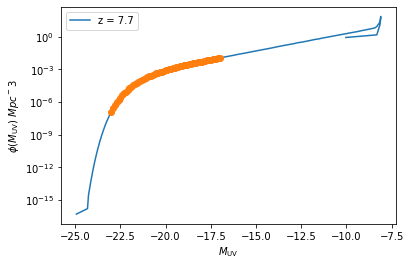

In [71]:
#Plot UV LF values vs interpolated Muv that is the same as EW 
def plot_UV_LF(log10_LF, zval_test):
        plt.semilogy(LF_tab['Muv'],LF_tab['ndens'],label = 'z = %.1f'%zval_test) #UV LF values (181 Muv vals)
        plt.plot(Muv_EW,new_ndens,'o')#EW Values along UV LF plot (61 Muv vals)
        #Muv values for EW are restricted in range, we'll have to extend range, use same EW PD > -23 and < -17 
        plt.legend()
        plt.xlabel('$M_\mathrm{UV}$')
        plt.ylabel(r'$\phi(M_\mathrm{UV})\ Mpc^-3$')
        plt.show()
        return
plot_UV_LF = plot_UV_LF(log10_LF,zval_test=7.7)

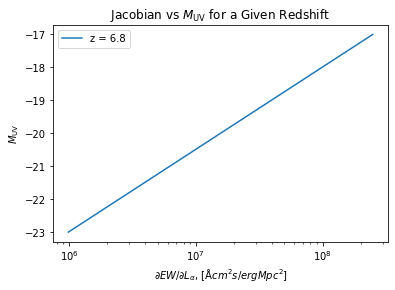

In [94]:
#Plot jacobian vs Muv
zval_test = np.array([5.9,6.8])
def plot_jvsMuv(log10_LF,zval_test):
#Shows a positive linear relationship b/t Muv and jacobian, (fd_uv vs Muv shows neg. LR)
#As Muv becomes fainter, value for jacobian increases, they're inversely proportional?
    for zz,zval2 in enumerate (LFz_tab): 
        if zval2 in zval_test:

            if zval2 == 5.9:
                my_color = 'gray'               
            else:
                my_color = 'purple'
                plt.semilogx(jacobian, Muv_EW, label = 'z = %.1f'%zval2)     
                plt.legend()
                plt.xlabel(r'$\partial EW/\partial L_\alpha$, [$\mathrm{\AA} cm^2 s/erg Mpc^2$]')
                plt.ylabel('$M_\mathrm{UV}$')
                plt.title('Jacobian vs $M_\mathrm{UV}$ for a Given Redshift ')
                return
plot_jvsMuv = plot_jvsMuv(log10_LF,zval_test)

# for zz in zval_test:
#     plot_jvsMuv = plot_jvsMuv(log10_LF, zval_test = zval_test)

# plot_jvsMuv = plot_jvsMuv(plt, log10_LF, zval_test = 5.9)
# plot_jvsMuv = plot_jvsMuv(plt, log10_LF, zval_test = 6.8)

/Users/alexamia/Desktop/REU2020_DATA/REU2020/data/models/M18_z=7.0_lnpWobs_Muv/ln_pWobs_xHI=0.36.txt
/Users/alexamia/Desktop/REU2020_DATA/REU2020/data/models/M18_z=7.0_lnpWobs_Muv/ln_pWobs_xHI=0.01.txt


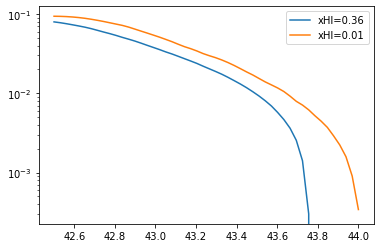

In [168]:
# xHI_array = np.array([0.01,0.15,0.36]) #chosen xHI value
# zval_test = np.array([5.9,6.8,7.9])

def make_lya_LF(zval_test, xHI_test):
    
    LFz_file = sorted(insensitive_glob(LFz_dir+ f'LF_pred_z{zval_test}.txt'))[0] 
    pW_file = sorted(insensitive_glob(pW_dir+f'ln_pWobs_*{xHI_test}.txt'))[0]
    
    print(pW_file)
    #Load in z value file
    LF_tab = load_uvf_pandas(LFz_file) 
    
    #Get Muv values from file as an array to use
    #Load in xHI value file
    pW_tab = load_uvf_pandas(pW_file)
    Muv_EW = np.array([float(Muv_val) for Muv_val in pW_tab.columns[1:]])
        
    #Interpolating UV LF Muv and ndens values into a 1d array
    LF_interp = interpolate.interp1d(LF_tab['Muv'],LF_tab['ndens']) #old values
    new_ndens = LF_interp(Muv_EW)


    d_l = P15.luminosity_distance(zval_test) #Defines distance modulus
    
    #Define apparent magnitude equation
    def muv(Muv_EW,d_l,zval_test): 
        p1 = Muv_EW
        p2 = 5*(np.log10((d_l/pc_10).to(u.pc/u.pc))) #convert d_l/pc_10 to pc units and then dimensionless
        p3 = 2.5*(beta+1.0)*np.log10(zval_test+1.0)
        ans = p1 + p2 + p3

        return ans
    muv = muv(Muv_EW,d_l,zval_test)


    #Flux density of UV continuum at Lya wavelength from Muv for given zvals
    fd_uv = f0 * (10**(-0.4*muv)) *(c/(wl_lya**2)) *((wl_lya/wl_uv)**(beta+2.0))
    fd_units = fd_uv.to(u.erg/u.s* (u.cm**(-2))/u.Angstrom) ##use this to show units

    #Jacobian - partial EW / partial Lya Luminosity for given zvals 
    jacobian = 1/((4*np.pi*d_l**2.)*fd_units)

    # Flux_Lya
    f_lya = np.outer(pW_tab['W'],fd_units) * u.Angstrom

    #Lya luminosity 
    lum_lya = (f_lya * (4*np.pi*d_l**2.)).to(u.erg/u.s)
    
    #Drops first column of EW values
    new_pW_tab = np.exp(pW_tab.drop('W',axis=1))
    #new_pW_tab = pW_tab.drop('W',axis=1) this was original code, was changed to exponential form

    #EW values for each Muv in EW file
    pEW_vals = np.array(new_pW_tab) 


    # P(Lya|Muv)
    pLya = jacobian * pEW_vals

    #Normalizes pLya to correctly plot lum_lya vs pLya
    A1 = pLya[0] #first term of p(L) integral, where these lum = 0 (the height in y)(-inf to 0)
    integral = np.trapz(pLya[1:].T,lum_lya.value[1:].T) #second term for lum>0 (L>0 to inf) transposed to correct matrix 
    sum_int = A1 + integral #This is whole integral of p(L)dL
    norm_pLya = pLya / sum_int #new normalized pLya, divide original pLya values by integral to normalize

    new_A1 = norm_pLya[0]
    integral2 = np.trapz(norm_pLya[1:].T,lum_lya.value[1:].T)
    new_sum = new_A1 + integral2 #verifies that new normalized integral adds up to 1 
    assert(new_sum.value.all() == 1.)

    #Define an empty matrix in order to fill later with luminosity grid values and Muv values
    new_pLya = np.zeros((len(lum_grid), len(Muv_EW))) 

    for mm,Muv in enumerate (Muv_EW):
        #Interpolating pLya and ndens values into a 1d array
        LF_interp = interpolate.interp1d(lum_lya[:,mm],norm_pLya[:,mm],fill_value='extrapolate') #old values, MUST BE 1D
        new_pLya[:,mm] = LF_interp(lum_grid) #column values of pLya

        #Product of UVLF ndens values * pLya in new luminosity grid
        product_LF = new_ndens * new_pLya 

        #Integral of this product = Lya LF (missing fudge factor corrections)
        lya_LF = np.trapz(product_LF) 

        #Log10 of Lya LF is lya_LF value * Jacobian - partial L / partial log10(L)
        log10_LF = lya_LF*np.log(10)*lum_grid

    return log10_LF
log10_LF = make_lya_LF(zval_test = 5.9,xHI_test = 0.36)
plt.semilogy(log10_lg, log10_LF, label = 'xHI=0.36')
log10_LF = make_lya_LF(zval_test = 5.9,xHI_test = 0.01)
plt.semilogy(log10_lg, log10_LF,label = 'xHI=0.01')
plt.legend()